<a href="https://colab.research.google.com/github/jrobledob/2025_APS_Workshop/blob/main/Code_4_Image_Classification_of_Diseased_Tomato_Leaves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Disease detection from images using CNN

The data set was retrieved from [Plant Village on Kaggle](https://www.kaggle.com/datasets/emmarex/plantdisease).

In [ ]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [ ]:
!gdown --id 1NpuJFX3XqOVE69sO4OXKERgy8jueTXrO --output data.zip

# Unzip the dataset
!unzip -q data.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1NpuJFX3XqOVE69sO4OXKERgy8jueTXrO
From (redirected): https://drive.google.com/uc?id=1NpuJFX3XqOVE69sO4OXKERgy8jueTXrO&confirm=t&uuid=9d18dcf7-b727-4fca-aee3-7422c0aaf84f
To: /content/data.zip
100% 44.3M/44.3M [00:00<00:00, 169MB/s]
replace train/Diseased/09c1a12a-ad44-4522-9755-851d6a042f02___GCREC_Bact.Sp 5585.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace train/Diseased/12159ce5-93ff-4ef3-b1ca-0bf130278818___GCREC_Bact.Sp 3565.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace train/Diseased/12159ce5-93ff-4ef3-b1ca-0bf130278818___GCREC_Bact.Sp 3565.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:



# Define image dimensions
img_width, img_height = 150, 150
target_size = (img_width, img_height)
batch_size = 32

# Set directories
train_dir = '/content/train'
validation_dir = '/content/validation'

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale pixel values from [0, 255] to [0, 1]
    rotation_range=40,         # Random rotation between 0 and 40 degrees
    width_shift_range=0.2,     # Random horizontal shift
    height_shift_range=0.2,    # Random vertical shift
    shear_range=0.2,           # Shear transformations
    zoom_range=0.2,            # Zoom in/out
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill in missing pixels after transformations
)

# Validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'  # Since it's a binary classification problem
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Important to keep data in the same order for evaluation
)

Found 1471 images belonging to 2 classes.
Found 811 images belonging to 2 classes.


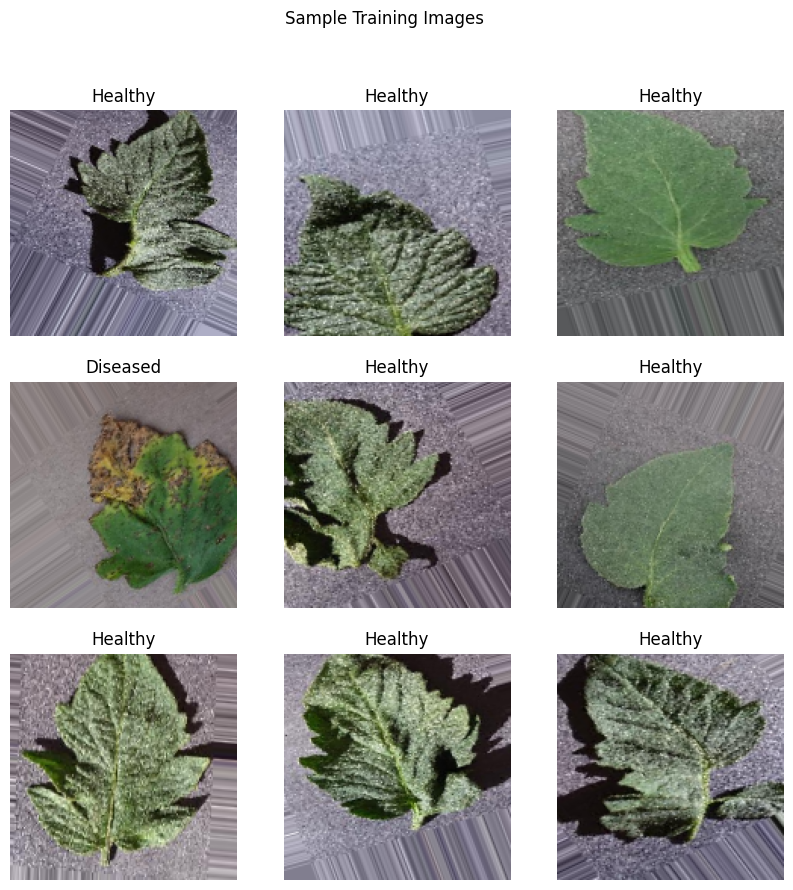

In [ ]:
# Visualize some healthy and diseased images
def plot_sample_images(generator, class_names, title):
    x_batch, y_batch = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(x_batch[i])
        class_idx = int(y_batch[i])
        plt.title(class_names[class_idx])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Get class indices
class_indices = train_generator.class_indices
# Mapping from class index to class label
class_names = {v: k for k, v in class_indices.items()}

# Plot sample images from training data
plot_sample_images(train_generator, class_names, 'Sample Training Images')

In [ ]:
# Initialize the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

# View model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --------------------------------------------------
# Configure training
# --------------------------------------------------
# @title 🚀 Training settings
EPOCHS = 10  # @param {type:"slider", min:1, max:50, step:1}
print(f"Training for {EPOCHS} epoch(s)…")

In [ ]:
# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 311ms/step - accuracy: 0.8468 - loss: 0.4114 - val_accuracy: 0.4112 - val_loss: 0.9395
Epoch 2/10
 1/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8125 - loss: 0.3761

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8125 - loss: 0.3761 - val_accuracy: 0.4112 - val_loss: 0.8044
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 459ms/step - accuracy: 0.8549 - loss: 0.3104 - val_accuracy: 0.4112 - val_loss: 0.9646
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8750 - loss: 0.2547 - val_accuracy: 0.5175 - val_loss: 0.5507
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 237ms/step - accuracy: 0.8931 - loss: 0.2502 - val_accuracy: 0.5663 - val_loss: 0.5655
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9375 - loss: 0.1373 - val_accuracy: 0.4437 - val_loss: 0.7736
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 217ms/step - accuracy: 0.9279 - loss: 0.1817 - val_accuracy: 0.9675 - val_loss: 0.1455
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9062 - loss: 0.2723 - val_accuracy: 0.4313 - val_loss: 1.0862
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.9493 - loss: 0.1272 - val_accuracy: 0.8850 - val_

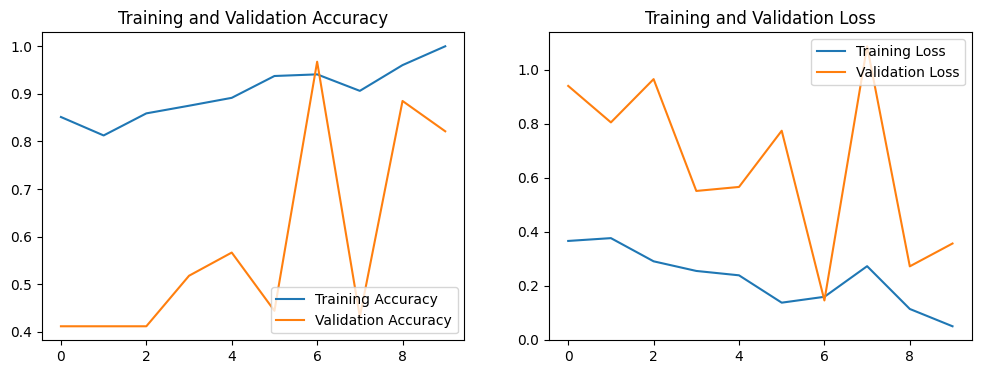

In [ ]:
# Plot training & validation accuracy/loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.7330 - loss: 0.5132
Test loss: 0.3514448404312134
Test accuracy: 0.8236744999885559
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


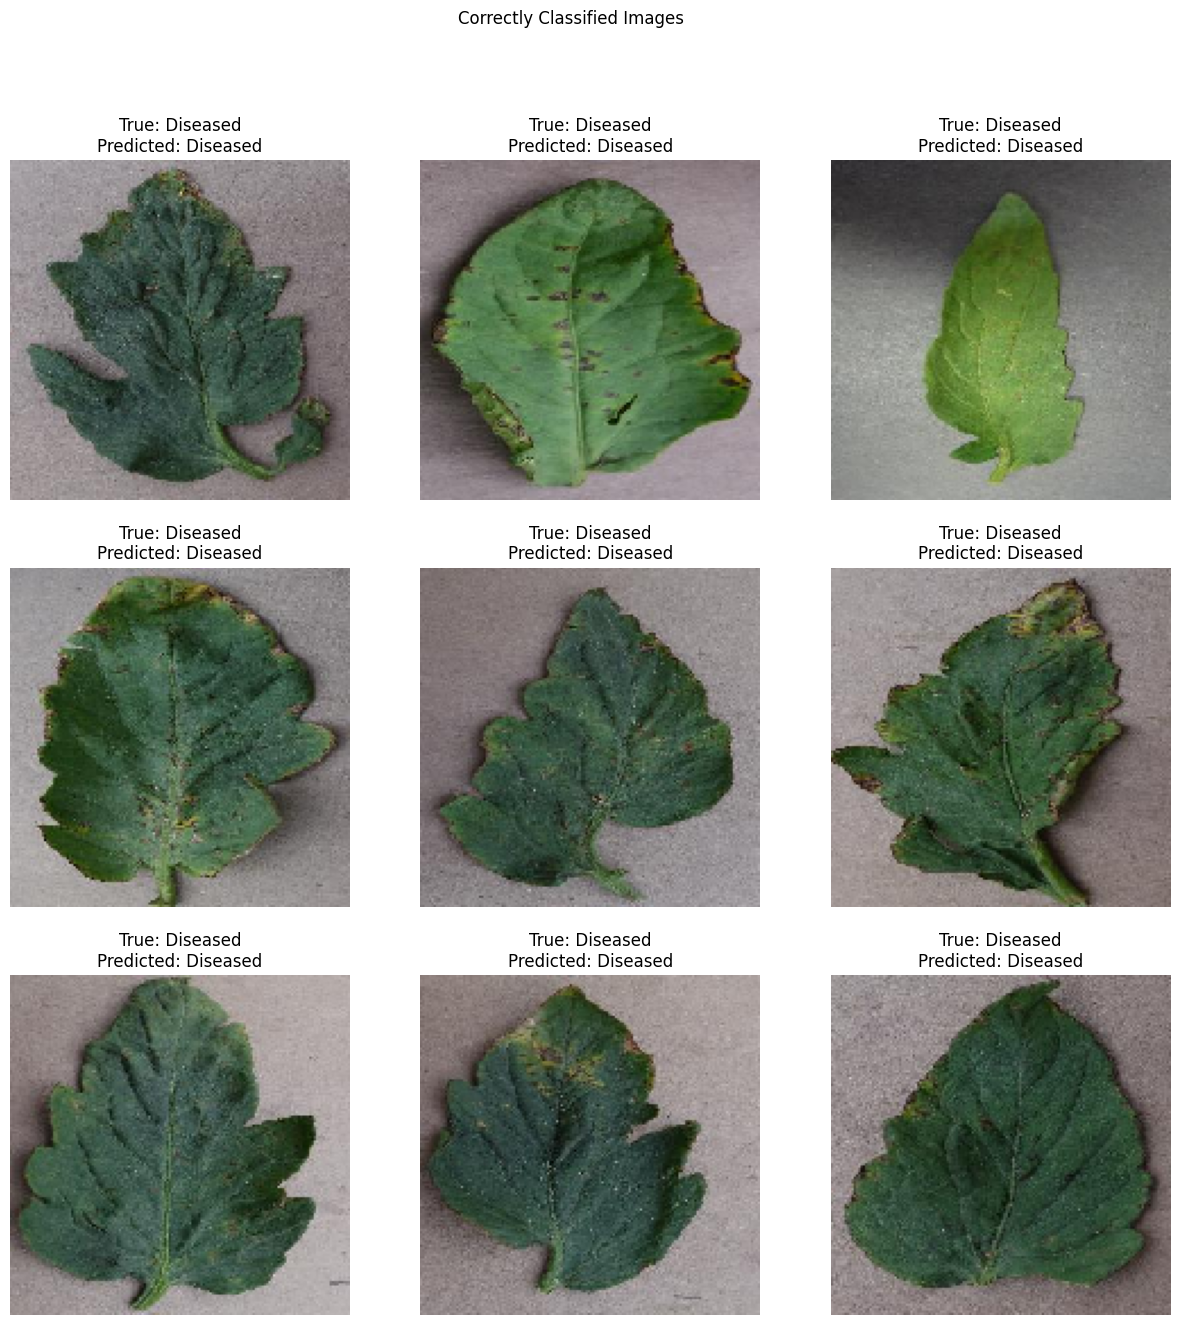

In [ ]:
# Evaluate on validation data
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f'Test loss: {validation_loss}')
print(f'Test accuracy: {validation_accuracy}')

# Make predictions on validation data
validation_generator.reset()  # Reset the generator
predictions = model.predict(validation_generator, steps=validation_generator.samples // batch_size + 1)
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)

# Get true labels
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Identify correctly and incorrectly classified images
correct = np.where(predicted_classes == true_classes)[0]
incorrect = np.where(predicted_classes != true_classes)[0]

# Function to plot images
def plot_images(indices, generator, title):
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(indices[:9]):  # Plot up to 9 images
        ax = plt.subplot(3, 3, i + 1)
        img_path = validation_generator.filepaths[idx]
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        plt.imshow(img_array)
        pred_label = class_names[predicted_classes[idx]]
        true_label = class_names[true_classes[idx]]
        plt.title(f'True: {true_label}\nPredicted: {pred_label}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot some correctly classified images
plot_images(correct, validation_generator, 'Correctly Classified Images')

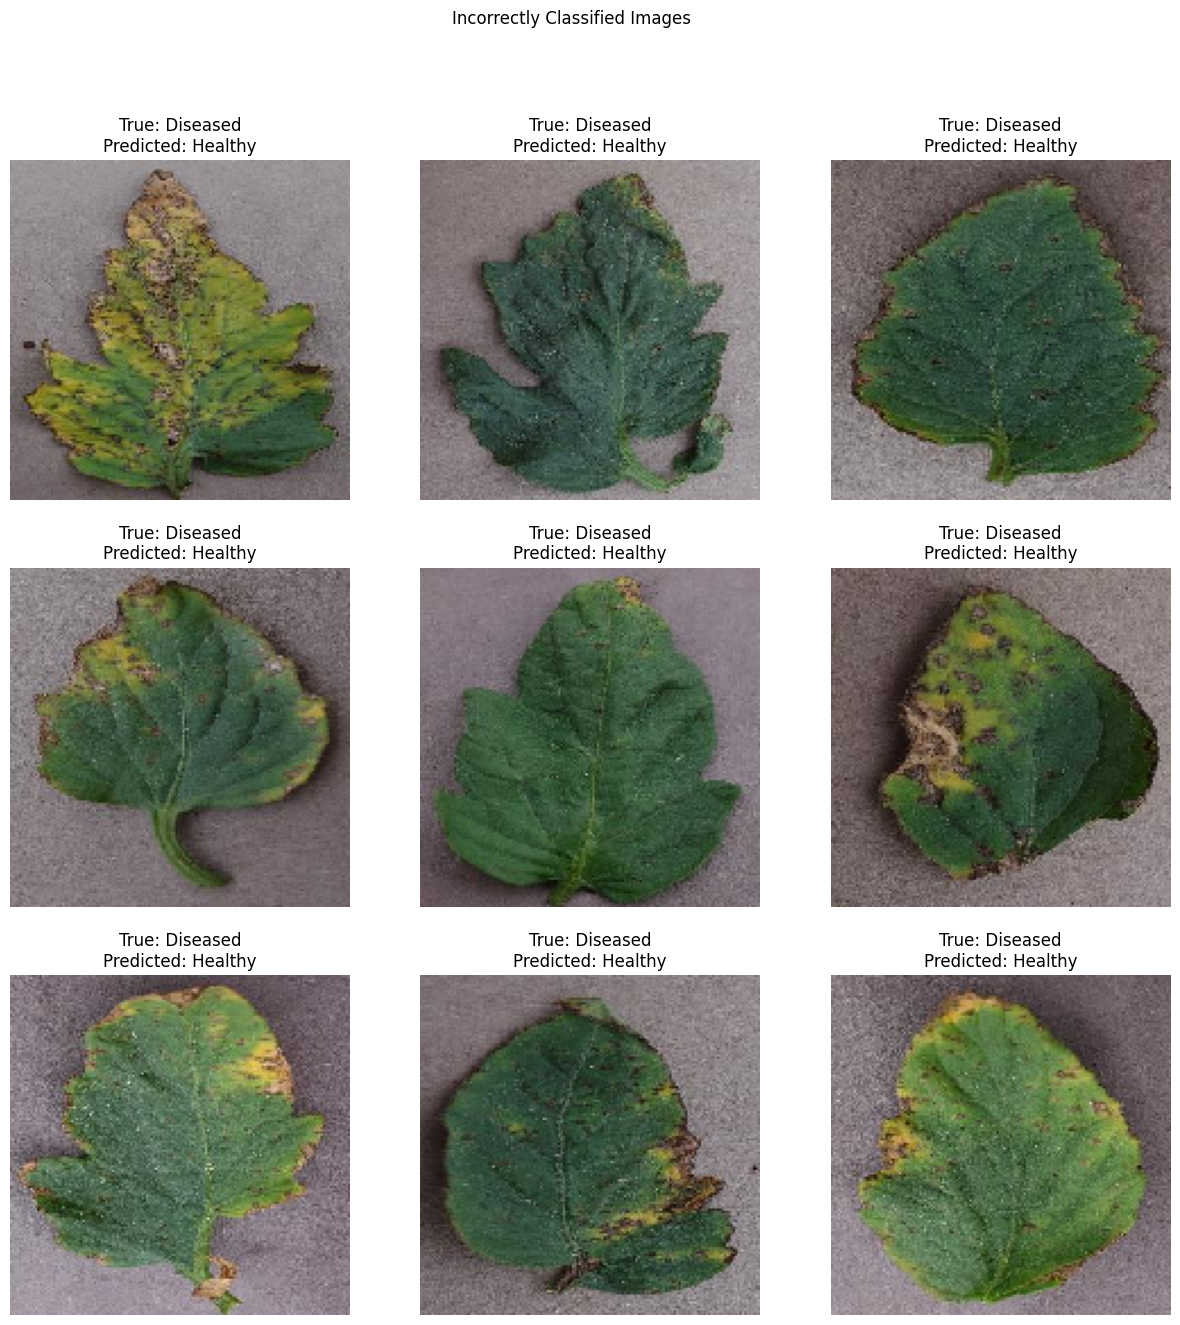

In [ ]:
# Plot some incorrectly classified images
plot_images(incorrect, validation_generator, 'Incorrectly Classified Images')

### Hands-On Section: Choosing the Number of Epochs

Now it's time to choose the number of epochs for training your model (change the slider above and run the code again). An epoch is one complete pass through the entire training dataset.

Keep in mind:

* More epochs mean more training time.

* After a certain point, performance might plateau—meaning the model stops improving significantly.Do you notice that happening in your case (see an example in this [link (Figure 15)](https://onlinelibrary.wiley.com/doi/10.1111/exsy.13454)?

In a real-world scenario, how would you handle this situation?
Feel free to ask ChatGPT for guidance!

### Test your model!

Upload a leaf photo and get a prediction

Select a JPG/PNG of a single leaf…


Saving 20250722_115919.jpg to 20250722_115919.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


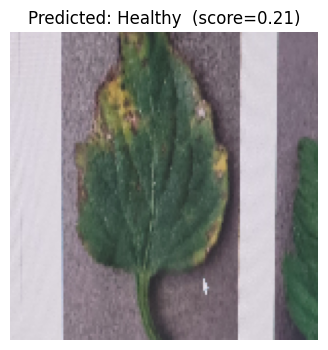

In [ ]:
# --------------------------------------------------
# 🔍 Upload your own leaf image and predict
# --------------------------------------------------
from google.colab import files
from tensorflow.keras.preprocessing import image as keras_image

# 1. Upload
print("Select a JPG/PNG of a single leaf…")
uploaded = files.upload()   # opens a file-picker in the browser

# 2. Pre-process & predict
for fname in uploaded.keys():
    # Load -> resize -> scale
    img = keras_image.load_img(fname, target_size=target_size)
    img_arr = keras_image.img_to_array(img) / 255.0
    img_arr = np.expand_dims(img_arr, axis=0)           # shape (1, H, W, 3)

    # Predict
    score = model.predict(img_arr)[0][0]                # sigmoid output
    label = "Diseased" if score > 0.5 else "Healthy"

    # 3. Show result
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {label}  (score={score:.2f})")
    plt.show()